In [12]:
from datetime import date 
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
temp_dir = tempfile.TemporaryDirectory()

import astropy.constants as C
import astropy.units as U
import illustris_python as il
import nifty8 as ift
from astropy.constants import c
from astropy.time import Time
from astropy.wcs import WCS
#from casatasks import exportfits, simobserve, tclean
#from casatools import table
from Hdecompose.atomic_frac import atomic_frac
#from illustris_python.snapshot import getSnapOffsets, loadSubset
from martini import DataCube, Martini
from martini.sources.sph_source import SPHSource
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import (AdaptiveKernel, CubicSplineKernel,
                                 GaussianKernel, find_fwhm)
from natsort import natsorted
from spectral_cube import SpectralCube
from tqdm import tqdm

In [2]:
from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af


******************************************************************************
Numba is not being used, either because it is disabled in `config/general.yaml` or because it is not installed.

. This will lead to slow performance.

. Install numba as described at the following webpage for improved performance. 
********************************************************************************


In [3]:
def sample_mass_distribution(mass_distribution: str, mass_centre: tuple, einstein_radius_low: float, 
                             einstein_radius_up: float ,lens_rs: float, source_rs:float, source2_rs):
    
    """a function to sample the mass distribution of the lens galaxy and the source galaxy. 
    Choose between broken power law (brokenPL), power law (PowerLow), and double Einstein ring (DoubleER)."""

    if mass_distribution == "brokenPL":
        mass = af.Model(al.mp.PowerLawBrokenSph)

        mass.centre = mass_centre
        mass.einstein_radius = af.UniformPrior(lower_limit=einstein_radius_low, upper_limit=einstein_radius_up)
        mass.inner_slope = 1.5
        mass.outer_slope = 0.5
        mass.break_radius = 0.01

        lens = af.Model(al.Galaxy, redshift=lens_rs, mass=mass)

        bulge = af.Model(al.lp_snr.ExponentialSph)

        bulge.centre_0 = af.GaussianPrior(mean=0.0, sigma=0.3)
        bulge.centre_1 = af.GaussianPrior(mean=0.0, sigma=0.3)
        bulge.signal_to_noise_ratio = af.UniformPrior(lower_limit=10.0, upper_limit=30.0)
        bulge.effective_radius = af.UniformPrior(lower_limit=0.01, upper_limit=3.0)

        source = af.Model(al.Galaxy, redshift=source_rs, bulge=bulge)
        return lens, source

    elif mass_distribution == "PowerLow":
        mass = af.Model(al.mp.PowerLaw)

        mass.centre = mass_centre
        mass.ell_comps.ell_comps_0 = af.GaussianPrior(
            mean=0.0, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
        )
        mass.ell_comps.ell_comps_1 = af.GaussianPrior(
            mean=0.0, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
        )
        mass.einstein_radius = af.UniformPrior(lower_limit=einstein_radius_low, upper_limit=einstein_radius_up)
        mass.slope = af.GaussianPrior(mean=2.0, sigma=0.1)

        shear = af.Model(al.mp.ExternalShear)

        shear.gamma_1 = af.GaussianPrior(mean=0.0, sigma=0.05)
        shear.gamma_2 = af.GaussianPrior(mean=0.0, sigma=0.05)

        lens = af.Model(al.Galaxy, redshift=lens_rs, mass=mass, shear=shear)

        bulge = af.Model(al.lp_snr.Sersic)

        bulge.centre_0 = af.GaussianPrior(mean=0.0, sigma=0.3)
        bulge.centre_1 = af.GaussianPrior(mean=0.0, sigma=0.3)
        bulge.ell_comps.ell_comps_0 = af.GaussianPrior(
            mean=0.0, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
        )
        bulge.ell_comps.ell_comps_1 = af.GaussianPrior(
            mean=0.0, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
        )
        bulge.signal_to_noise_ratio = af.UniformPrior(lower_limit=10.0, upper_limit=30.0)
        bulge.effective_radius = af.UniformPrior(lower_limit=0.01, upper_limit=3.0)
        bulge.sersic_index = af.GaussianPrior(
            mean=2.0, sigma=0.5, lower_limit=0.8, upper_limit=5.0
        )

        source = af.Model(al.Galaxy, redshift=source_rs, bulge=bulge)
        return lens, source
    
    elif mass_distribution == "DoubleER":
        mass = af.Model(al.mp.Isothermal)

        mass.centre = mass_centre
        mass.einstein_radius = af.GaussianPrior(mean=1.8, sigma=0.3, lower_limit=0.0)

        lens = af.Model(al.Galaxy, redshift=lens_rs, mass=mass)

        bulge = af.Model(al.lp_snr.ExponentialSph)

        bulge.centre_0 = af.GaussianPrior(mean=0.0, sigma=0.1)
        bulge.centre_1 = af.GaussianPrior(mean=0.0, sigma=0.1)
        bulge.signal_to_noise_ratio = af.UniformPrior(lower_limit=20.0, upper_limit=30.0)
        bulge.effective_radius = af.GaussianPrior(
            mean=0.2, sigma=0.2, lower_limit=0.01, upper_limit=3.0
        )

        mass = af.Model(al.mp.IsothermalSph)

        mass.centre_0 = bulge.centre_0
        mass.centre_1 = bulge.centre_1

        mass.einstein_radius = af.UniformPrior(lower_limit=einstein_radius_low, upper_limit=einstein_radius_up)

        source_0 = af.Model(al.Galaxy, redshift=source_rs, bulge=bulge, mass=mass)
        source_1 = af.Model(al.Galaxy, redshift=source2_rs, bulge=bulge)
        return lens, source_0, source_1
    
    else:
        raise ValueError("Mass distribution not supported.")

     


In [7]:
exposure_time = 300.0
background_sky_level = 0.1
mass_distribution = "DoubleER"
mass_centre = (0.0, 0.0)
einstein_radius_low = 1.0
einstein_radius_up = 2.0
lens_rs = 0.5
source_rs = 1.0
source2_rs = 2.0
total_datasets = 5
lens, source_0, source_1 = sample_mass_distribution(mass_distribution, mass_centre, einstein_radius_low, 
                                        einstein_radius_up, lens_rs, source_rs, source2_rs)
print(type(lens))


<class 'autofit.mapper.prior_model.prior_model.Model'>


https://arxiv.org/pdf/0906.2013.pdf
https://iris.sissa.it/retrieve/dd8a4bf9-0cca-20a0-e053-d805fe0a8cb0/art/stac585_f1a.eps
https://iopscience.iop.org/article/10.3847/2041-8213/aa7d4a
https://arxiv.org/pdf/0906.2013.pdf



In [11]:
def simulate_strong_lens(total_datasets:int, dataset_label:str, dataset_type: str, dataset_sample_name: str, 
                            exposure_time:float, background_sky_level:float, mass_distribution: str, mass_centre: tuple, einstein_radius_low: float, 
                            einstein_radius_up: float ,lens_rs: float, source_rs:float, source2_rs ):
    #The path where the dataset will be output
    dataset_path = path.join("dataset", dataset_type, dataset_label, dataset_sample_name)
    #use the Grid2DIterate object.
    grid = al.Grid2DIterate.uniform(
    shape_native=(150, 150),
    pixel_scales=0.1,
    fractional_accuracy=0.9999,
    sub_steps=[2, 4, 8, 16, 24],
)
    psf = al.Kernel2D.from_gaussian(
    shape_native=(11, 11), sigma=0.2, pixel_scales=grid.pixel_scales
)
    simulator = al.SimulatorImaging(
    exposure_time=exposure_time, psf=psf, background_sky_level=background_sky_level, add_poisson_noise=True
)

    for sample_index in range(total_datasets):
        if mass_distribution == "brokenPL" or mass_distribution == "PowerLow":
            dataset_sample_path = path.join(dataset_path, f"dataset_{sample_index}")

            lens, source = sample_mass_distribution(mass_distribution, mass_centre, einstein_radius_low, 
                             einstein_radius_up ,lens_rs, source_rs, source2_rs)

            lens_galaxy = lens.random_instance()
            source_galaxy = source.random_instance()

            """
            __Ray Tracing__
            
            Use the sample's lens and source galaxies to setup a tracer, which will generate the image for the 
            simulated `Imaging` dataset.
            
            The steps below are expanded on in other `imaging/simulator` scripts, so check them out if anything below is unclear.
            """
            tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

            # ----------------------------------------------
            NUMPY ARRAY 

            tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
            tracer_plotter.figures_2d(image=True)

            dataset = simulator.via_tracer_from(tracer=tracer, grid=grid)

            dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
            dataset_plotter.subplot_dataset()

            """
            __Output__
            
            Output the simulated dataset to the dataset path as .fits files.
            
            This uses the updated `dataset_path_sample` which outputs this sample lens to a unique folder.
            """
            dataset.output_to_fits(
                data_path=path.join(dataset_sample_path, "data.fits"),
                psf_path=path.join(dataset_sample_path, "psf.fits"),
                noise_map_path=path.join(dataset_sample_path, "noise_map.fits"),
                overwrite=True,
            )

        
        elif mass_distribution == "DoubleER":
            dataset_sample_path = path.join(dataset_path, f"dataset_{sample_index}")

            lens, source_0, source_1 = sample_mass_distribution(mass_distribution, mass_centre, einstein_radius_low, 
                             einstein_radius_up ,lens_rs, source_rs, source2_rs)

            lens_galaxy = lens.random_instance_from_priors_within_limits()
            source_galaxy_0 = source_0.random_instance_from_priors_within_limits()
            source_galaxy_1 = source_1.random_instance_from_priors_within_limits()

            """
            __Ray Tracing__
            
            Use the sample's lens and source galaxies to setup a tracer, which will generate the image for the 
            simulated `Imaging` dataset.
            
            The steps below are expanded on in other `imaging/simulator` scripts, so check them out if anything below is unclear.
            """
            tracer = al.Tracer.from_galaxies(
                galaxies=[lens_galaxy, source_galaxy_0, source_galaxy_1]
            )

            tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
            tracer_plotter.figures_2d(image=True)

            dataset = simulator.via_tracer_from(tracer=tracer, grid=grid)

            dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
            dataset_plotter.subplot_dataset()

            """
            __Output__
            
            Output the simulated dataset to the dataset path as .fits files.
            
            This uses the updated `dataset_path_sample` which outputs this sample lens to a unique folder.
            """
            dataset.output_to_fits(
                data_path=path.join(dataset_sample_path, "data.fits"),
                psf_path=path.join(dataset_sample_path, "psf.fits"),
                noise_map_path=path.join(dataset_sample_path, "noise_map.fits"),
                overwrite=True,
            )

            """
            __Visualize__
            
            Output a subplot of the simulated dataset, the image and the tracer's quantities to the dataset path as .png files.

            For a faster run time, the tracer visualization uses the binned grid instead of the iterative grid.
            """
            mat_plot = aplt.MatPlot2D(
                output=aplt.Output(path=dataset_sample_path, format="png")
            )

            dataset_plotter = aplt.ImagingPlotter(dataset=dataset, mat_plot_2d=mat_plot)
            dataset_plotter.subplot_dataset()
            dataset_plotter.figures_2d(data=True)

            tracer_plotter = aplt.TracerPlotter(
                tracer=tracer, grid=grid.binned, mat_plot_2d=mat_plot
            )
            tracer_plotter.subplot_tracer()
            tracer_plotter.subplot_plane_images()

            """
            __Tracer json__

            Save the `Tracer` in the dataset folder as a .json file, ensuring the true light profiles, mass profiles and galaxies
            are safely stored and available to check how the dataset was simulated in the future. 
            
            This can be loaded via the method `Tracer.from_json`.
            """
            tracer.output_to_json(file_path=path.join(dataset_sample_path, "tracer.json"))

            """
            The dataset can be viewed in the 
            folder `autolens_workspace/imaging/sample/mass_sie__source_sersic_{sample_index]`.
            """
        else:
            raise ValueError("Mass distribution not supported.")


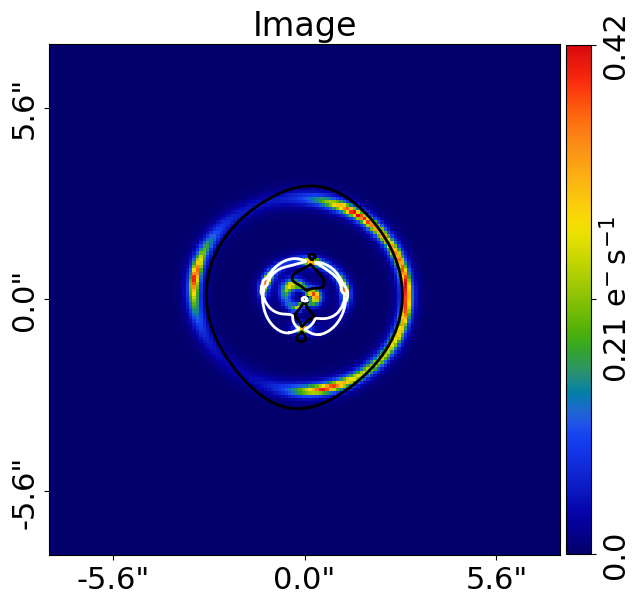

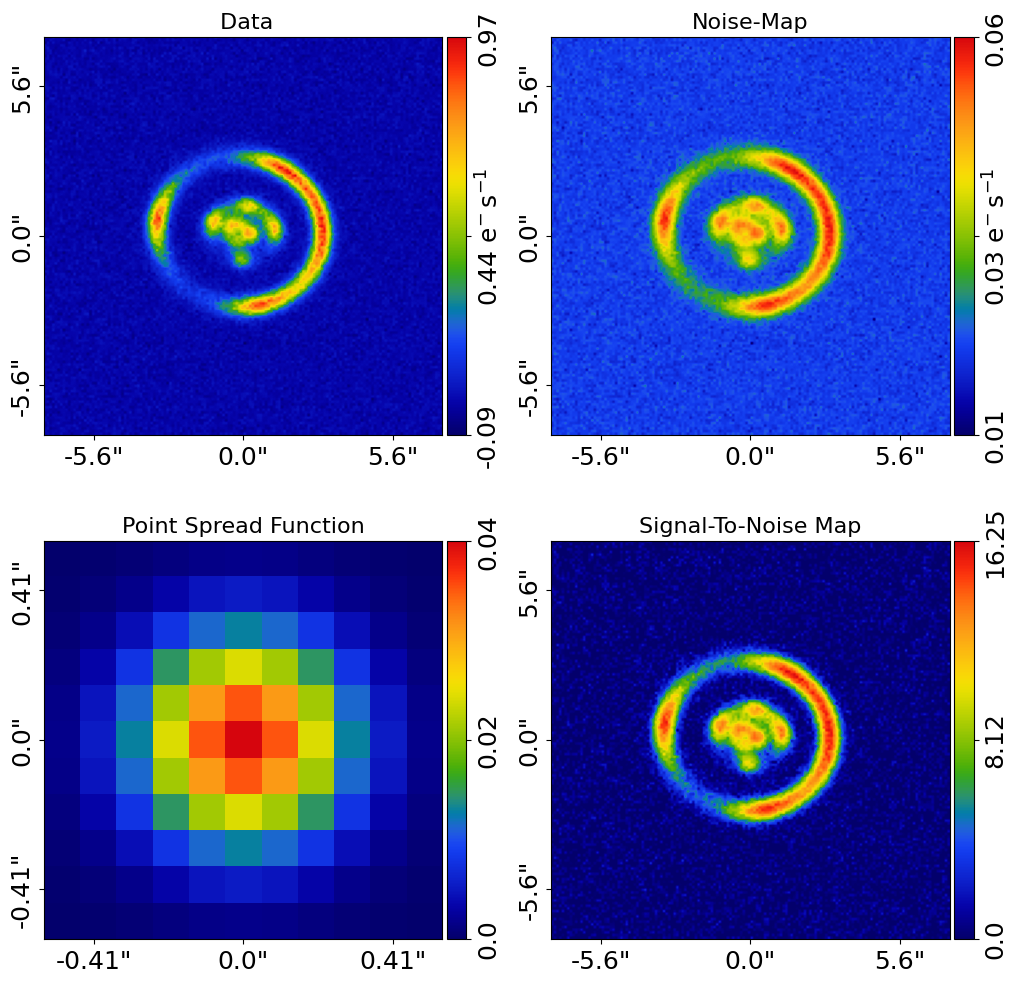

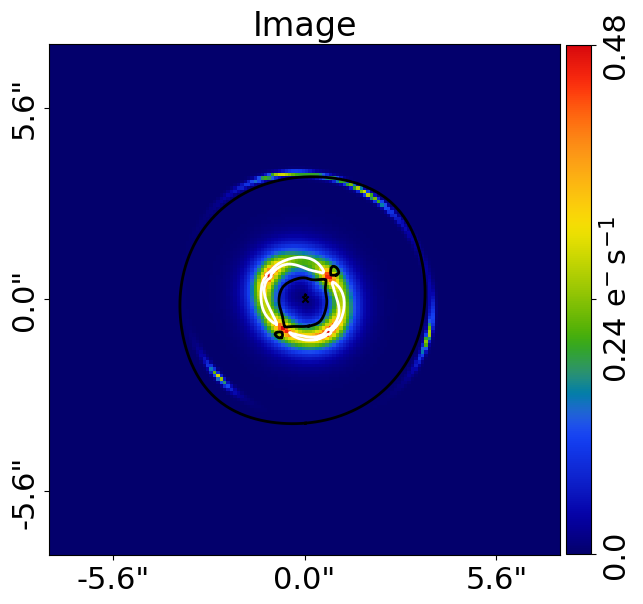

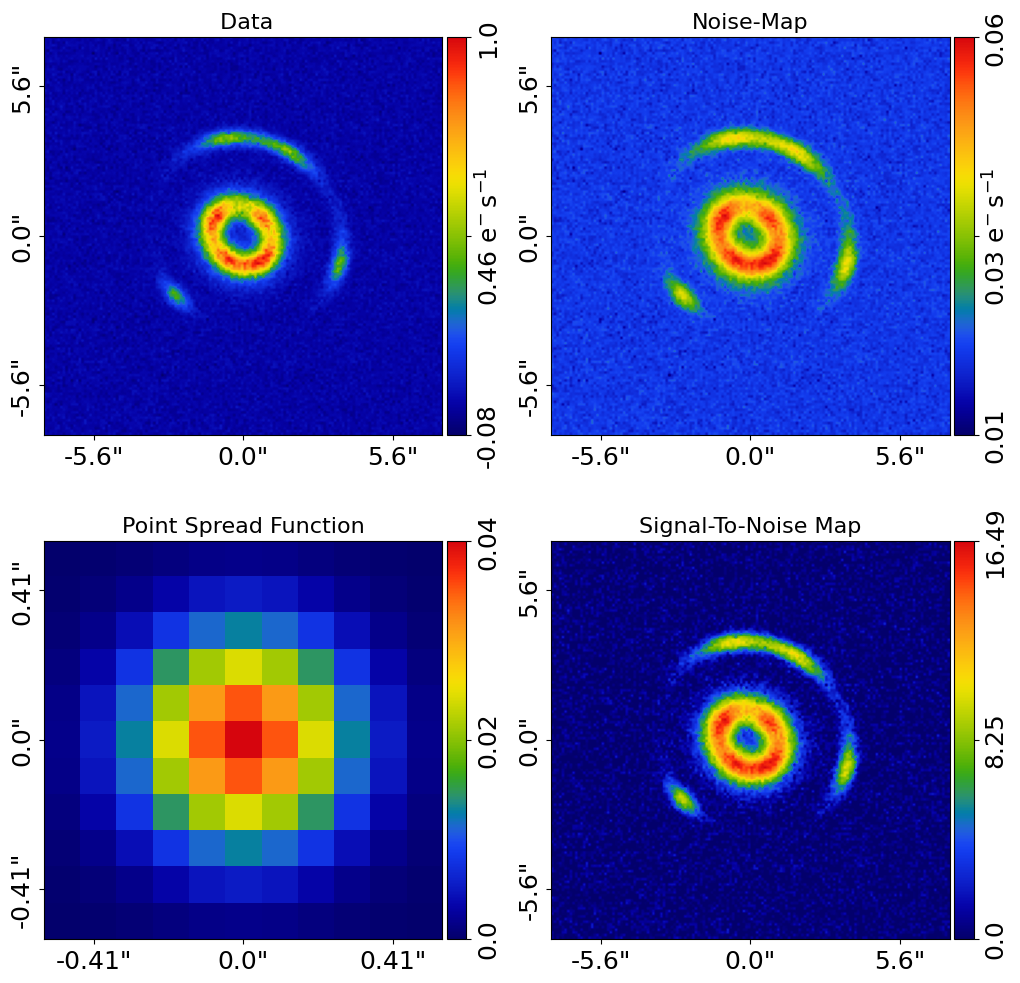

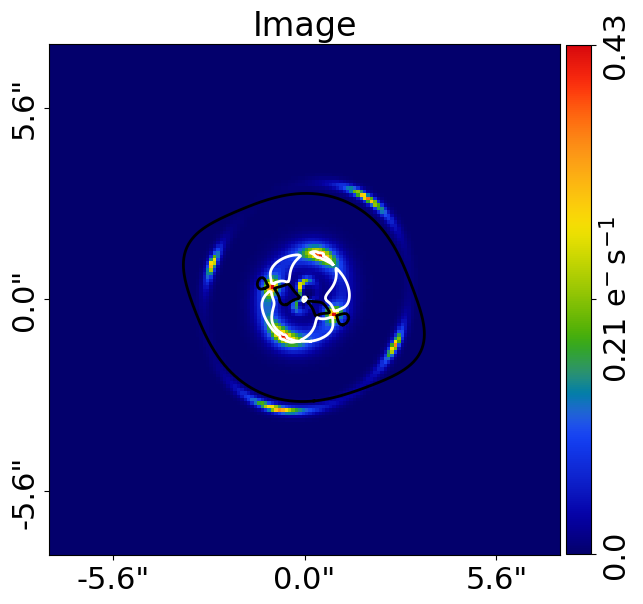

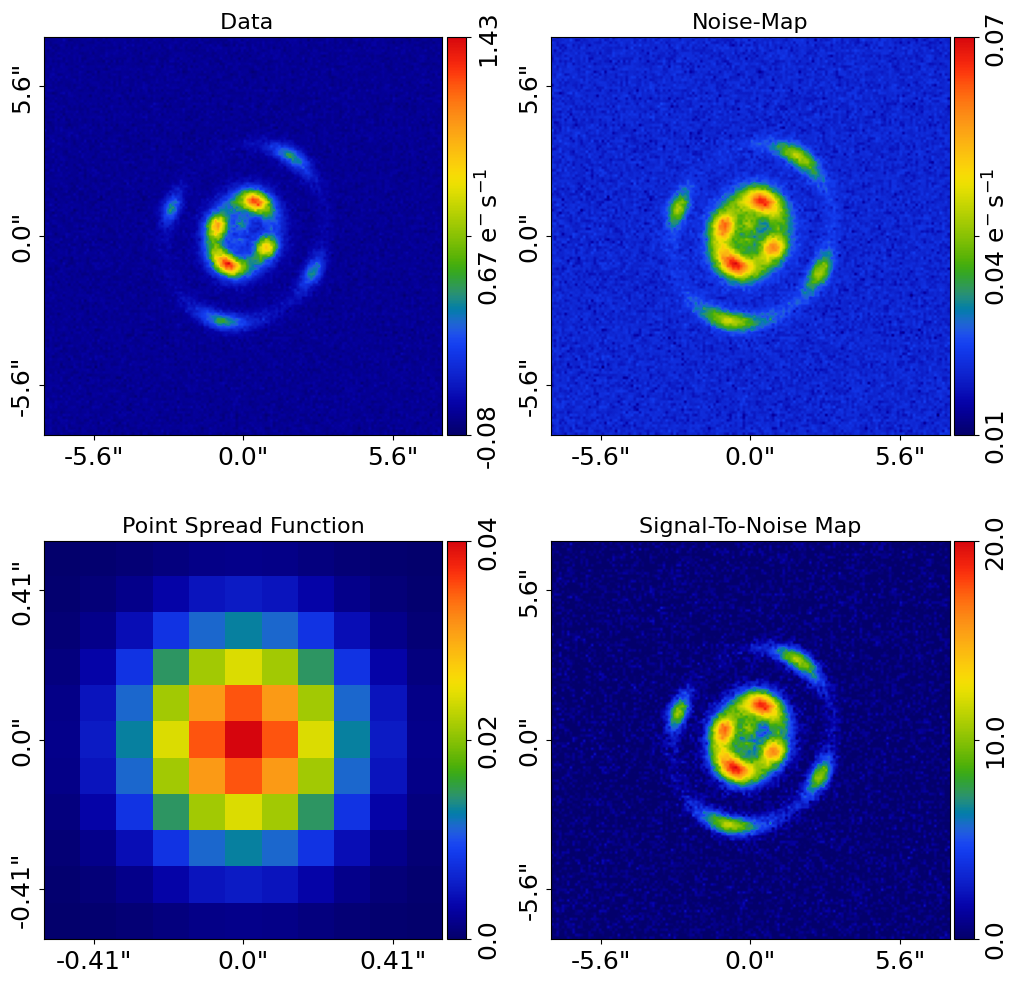

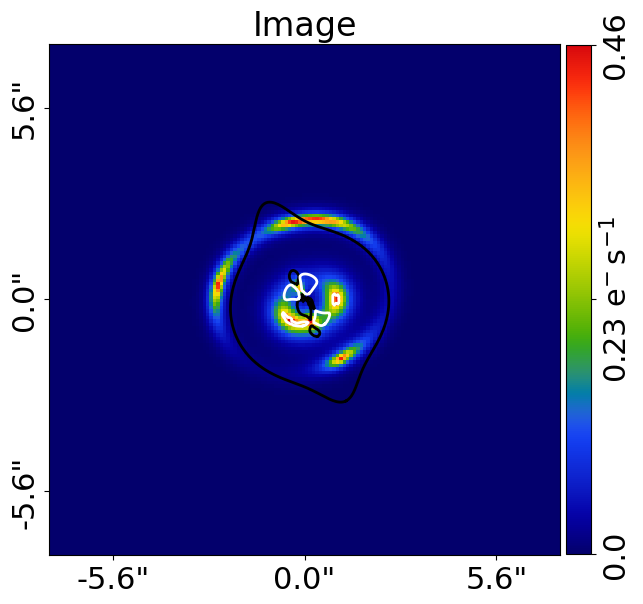

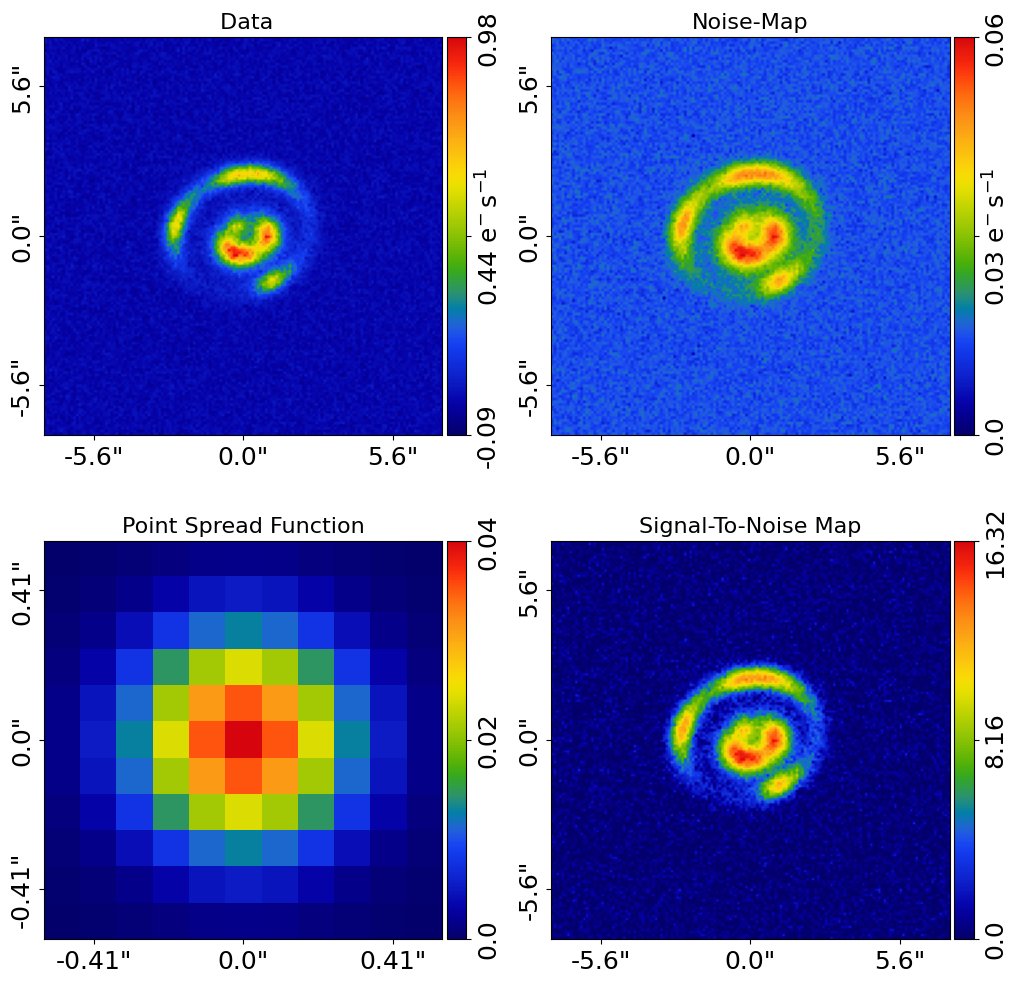

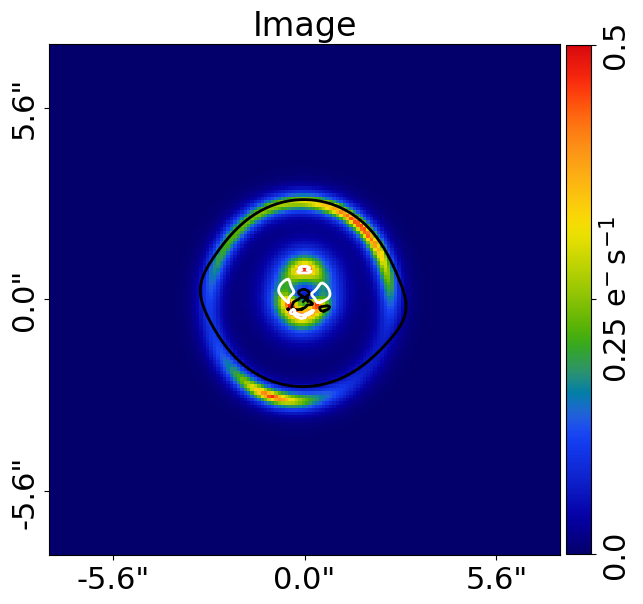

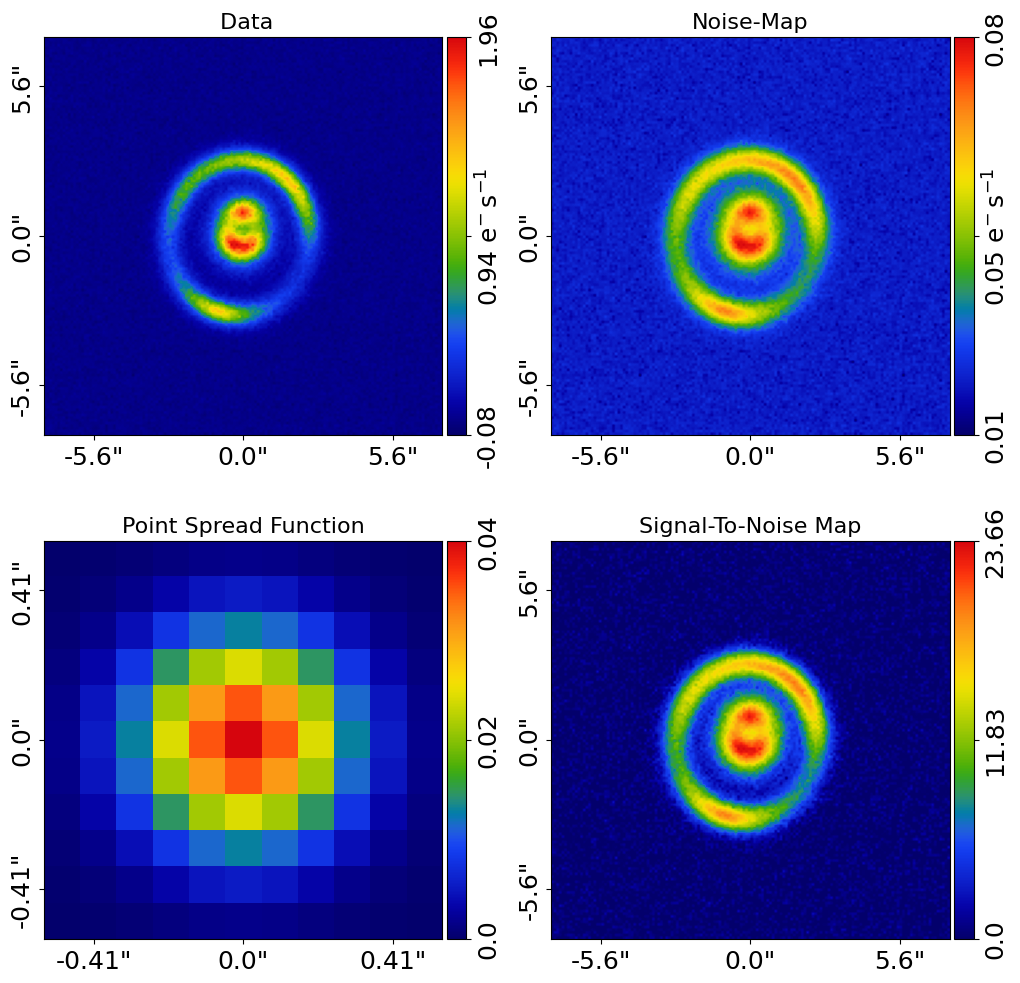

In [15]:
### test the function ####
dataset_label = "samples"
dataset_type = "imaging"
dataset_sample_name = "double_einstein_ring"
exposure_time = 300.0
background_sky_level = 0.1
mass_distribution = "DoubleER"
mass_centre = (0.0, 0.0)
einstein_radius_low = 1.0
einstein_radius_up = 2.0
lens_rs = 0.5
source_rs = 1.0
source2_rs = 2.0
total_datasets = 5

simulate_strong_lens(total_datasets, dataset_label, dataset_type, dataset_sample_name,
                    exposure_time, background_sky_level, mass_distribution, mass_centre, einstein_radius_low, 
                    einstein_radius_up ,lens_rs, source_rs, source2_rs )